In [11]:
import math
import numpy as np
from tqdm import tqdm
from icecream import ic
import cProfile 
import time
import warnings

In [12]:
#warning settings
np.seterr(all="ignore") #ignore np warnings, the output will be nan or inf and will be handled correctly in the code. (using np.errstate slows down the code)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [13]:
# Configuration
TRAIN_TEST_RATIO=0.8
PROBLEM_NUMBER=7

### Function definitions

In [14]:
# Normalize the training and testing data
def normalize_data(x, y, feature_range=(0, 1)):
    """
    Normalize input (x) and output (y) data using min-max normalization.

    Parameters:
        x: np.ndarray, input data (variables, samples).
        y: np.ndarray, output data (samples).
        feature_range: tuple (min, max), range for normalization.

    Returns:
        x_norm: Min-max normalized input data.
        y_norm: Min-max normalized output data.
        x_stats: Dict containing min and max for x.
        y_stats: Dict containing min and max for y.
    """
    x_min = np.min(x, axis=1, keepdims=True)
    x_max = np.max(x, axis=1, keepdims=True)
    x_norm = (x - x_min) / (x_max - x_min) * (feature_range[1] - feature_range[0]) + feature_range[0]

    y_min = np.min(y)
    y_max = np.max(y)
    y_norm = (y - y_min) / (y_max - y_min) * (feature_range[1] - feature_range[0]) + feature_range[0]

    x_stats = {"min": x_min, "max": x_max}
    y_stats = {"min": y_min, "max": y_max}

    return x_norm, y_norm, x_stats, y_stats

### Data Loading and Data Preprocessing

In [15]:
# Load problem data with context manager protocol
with np.load(f'data/problem_{PROBLEM_NUMBER}.npz') as problem:
    x_1 = problem['x']
    y_1 = problem['y']

# Shuffle the data
permutation = np.random.permutation(len(y_1))
x_1 = x_1[:, permutation]
y_1 = y_1[permutation]

# Determine train test split sizes
problem_len=len(y_1)
train_size=int(TRAIN_TEST_RATIO*problem_len)

# Split data
x_train = x_1[:, :train_size]
y_train = y_1[:train_size]

x_test = x_1[:, train_size:]
y_test = y_1[train_size:]

# Normalize training and testing data
# x_train_norm, y_train_norm, x_stats, y_stats = normalize_data(x_train, y_train)
# x_test_norm, y_test_norm, _, _ = normalize_data(x_test, y_test)

# To view the npz file, run python -m npzviewer 
# Print dataset information
print(f"Problem number: {PROBLEM_NUMBER}, variables: {x_1.shape[0]}, train size: {train_size}, test size: {problem_len-train_size}")
# print(f"Training data: x shape {x_train_norm.shape}, y shape {y_train_norm.shape}")
# print(f"Testing data: x shape {x_test_norm.shape}, y shape {y_test_norm.shape}")


Problem number: 7, variables: 2, train size: 4000, test size: 1000


### Numpy functions definition

In [16]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    # np.arcsin,
    # np.arccos,
    # np.arctan,
    # np.ceil,
    # np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    # np.maximum,
    # np.minimum,
    # np.mod
]

### Symbolic Regression Class

In [17]:
from tree import Tree

class SymbolicRegression:
    def __init__(self, population_size, max_generations, mutation_rate, elitism_size, grow_full_ratio):
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio

        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.best_fitness_history = []
        
        self.population = np.array([
            Tree("grow") if i < int(population_size * self.grow_full_ratio) else Tree("full")
            for i in range(population_size)
        ])

    # Parents selection methods
    def select_parents_fitness_proportional(self, n_elems=2, epsilon=1e-10):
        """
        Individuals with lower fitness have an higher probability to be selected.
        Premature convergence if few individuals have significantly better fitness than others.
        """
        fitnesses = [tree.fitness for tree in self.population]
        inverted_fitnesses = [1 / (fitness + epsilon) for fitness in fitnesses]  # avoid division by zero
        probabilities = inverted_fitnesses / sum(inverted_fitnesses)
        parent1, parent2 = np.random.choice(self.population, size=n_elems, p=probabilities, replace=False)
        return parent1, parent2
    
    def select_parents_lexicase(self):  # TODO: implement this
        pass

    def select_parents_rank_based(self, n_elems=2):
        """
        Rank-based selection method.
        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        """
        fitnesses = np.array([tree.fitness for tree in self.population])
        ranks = np.argsort(fitnesses)
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population, n_elems, p=probabilities, replace=False)
    
    def select_parents_tournament(self):
        tournament_size = 7
        tournament = list(np.random.choice(self.population, tournament_size, replace=False))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]
    
    def select_parents(self):
        return self.select_parents_rank_based()

    # Mutation methods
    def mutate(self, tree):
        if np.random.rand() < 0.5:
            tree.mutate_subtree()
        else:
            tree.mutate_single_node()

    # Offsprings generation via mutation and crossover
    def offspring_generation(self):
        new_population = np.array([])

        # Elitism   
        elite_individuals = self.population[:self.elitism_size]
        new_population = elite_individuals

        # Main loop
        while len(new_population) < self.population_size: #//2:
            parent1, parent2 = self.select_parents()

            # generate offsprings (one in mutation, two in crossover)
            offsprings = np.array([])

            if(np.random.rand() < self.mutation_rate):
                parent_clone = parent1.copy_tree()
                self.mutate(parent_clone)
                Tree.collapse_branch(parent_clone.root)
                parent_clone.compute_fitness()
                # if(parent_clone not in new_population):
                offsprings = np.append(offsprings, [parent_clone])

            else:    
                offspring1, offspring2 = Tree.crossover(parent1, parent2)
                if(offspring1 is not None or offspring2 is not None):
                    Tree.collapse_branch(offspring1.root)
                    Tree.collapse_branch(offspring2.root)
                
                    # self.mutate(offspring1)
                    # self.mutate(offspring2)

                    #Trying stuff
                    # offspring1.compute_fitness()
                    # offspring2.compute_fitness()
                    # tmp_fitnesses=[tree.fitness for tree in new_population]
                    # if offspring1.fitness not in tmp_fitnesses:
                    #     offsprings.append(offspring1)
                    # if offspring2.fitness not in tmp_fitnesses:
                    #     offsprings.append(offspring2)
                    
                    offspring1.compute_fitness()
                    offspring2.compute_fitness()

                    #if osspring1 is not alredy in population, already defined the eq as the fitness comparison
                    # if offspring1 not in new_population:
                    #     offsprings = np.append(offsprings, [offspring1])
                    # if offspring2 not in new_population:
                    #     offsprings = np.append(offsprings, [offspring2])

                    offsprings = np.append(offsprings, [offspring1, offspring2])

            new_population = np.concatenate((new_population, offsprings))
                
        return new_population
    
    # Genetic Algorithm: Evolutionary Process
    def evolve(self):
        best_tree = None
        best_fitness = np.inf
        take_over = False
        # self.population.sort(key=lambda x: x.fitness) 
        #numpy sort of population over fitness
        self.population.sort()
        # print(f"Initial best fitness: {self.population[0].fitness}")
        # print(f"Initial best fitness: {self.population[1].fitness}")
        # print(f"Initial best fitness: {self.population[2].fitness}")
        # print(f"Initial worst fitness: {self.population[-1].fitness}")

        for generation in tqdm(range(self.max_generations)):
            
            if take_over:
                # trasform the population in set and then back to list to remove duplicates
                self.population = np.unique(self.population)
                # sort the population based on fitness
                self.population.sort()
                self.population = self.population[:int(self.population_size*0.1)]
                new_trees = np.array([Tree("grow") for _ in range(int(self.population_size*0.3))]+[Tree("grow") for _ in range(int(self.population_size*0.3))])
                self.population=np.concatenate((self.population,new_trees))
            
            new_population=self.offspring_generation()

            # for tree in new_population:
            #     tree.compute_fitness()
                
            self.population=np.concatenate((self.population,new_population))
            
            generation_fitnesses = [tree.fitness for tree in self.population]
            generation_best_fitness = min(generation_fitnesses)

            if generation_best_fitness < best_fitness:
                best_fitness = generation_best_fitness
                best_tree = self.population[np.argmin(generation_fitnesses)]
                self.best_fitness_history.append(best_fitness)
            #trim the population to the best population_size
            self.population.sort()
            self.population = self.population[:self.population_size]
            # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
            

            n_best = [elem for elem in self.population if elem.fitness == self.population[0].fitness]
            take_over = False
            if len(n_best) > 0.9 * self.population_size:
                    take_over = True
                    # print(f"Takeover at {generation} gen")     
            if(generation%100==0):
                print(f"Generation {generation + 1}, Best Fitness: {best_fitness}, Best Formula: {best_tree.to_np_formula()}")
            if best_fitness <= 1e-33:
                break   

        return best_tree, best_fitness

### Problem Definition and Symbolic Regression Initialization

In [18]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 1000
MUTATION_RATE = 0.1
ELITISM_SIZE = 1
GROW_FULL_RATIO = 1

TREE_DEPTH = min(math.ceil(math.log(x_train.shape[0] + 1, 2)) + 2, 10)  # FIXME: temporary solution,IDK if it's good. (it's the depth to contain all the variables+1)
print("Tree depth: ",TREE_DEPTH)

VAR_NUM = x_train.shape[0]
CONST_RANGE = 10 # Constats will be in the range [-CONST_RANGE, CONST_RANGE]

# Tree.set_params(unary_ops, binary_ops, VAR_NUM, 10, TREE_DEPTH, x_train_norm, y_train_norm, x_test_norm, y_test_norm)
Tree.set_params(unary_ops, binary_ops, VAR_NUM, 10, TREE_DEPTH, x_train, y_train, x_test, y_test)
regressor = SymbolicRegression(
    POPULATION_SIZE,
    MAX_GENERATIONS,
    MUTATION_RATE,
    ELITISM_SIZE,
    GROW_FULL_RATIO
    #(x_train, y_train)   # per lexicase
)

Tree depth:  4


### Formula Revertion and Fitness Computation

In [19]:
#UNCOMMENT TO PROFILE THE CODE (and comment the rest of the code)
# cProfile.run("regressor.evolve()",sort="tottime") #for profiling so we can see the time taken by each function
#the output will include the following columns:
#tottime: Total time spent in the function (excluding time spent in other functions it calls).
#cumtime: Cumulative time spent in the function (including time spent in sub-functions).
def revert_formula(formula, x_stats, y_stats):
    """
    Revert a formula from normalized space to original space for min-max normalization.

    Parameters:
        formula: str, symbolic regression formula in normalized space.
        x_stats: dict, stats for input normalization (min, max).
        y_stats: dict, stats for output normalization (min, max).

    Returns:
        str, formula in the original space.
    """
    x_mins = x_stats["min"].flatten()
    x_maxs = x_stats["max"].flatten()
    y_min = y_stats["min"]
    y_max = y_stats["max"]

    # Wrap variables with normalization transformations
    for i, (x_min, x_max) in enumerate(zip(x_mins, x_maxs)):
        formula = formula.replace(
            f"x[{i}]",
            f"(x[{i}] * ({x_max} - {x_min}) + {x_min})"
        )

    # Apply the output transformation
    reverted_formula = f"(({formula}) * ({y_max} - {y_min})) + {y_min}"
    return reverted_formula

def compute_fitness_from_formula(formula, x_data, y_data):
    """
    Compute MSE fitness directly from a reverted formula.

    Parameters:
        formula: str, reverted symbolic regression formula.
        x_data: np.ndarray, input data in original scale (variables, samples).
        y_data: np.ndarray, true output data in original scale (samples).

    Returns:
        float, MSE fitness.
    """
    # Convert the formula to a lambda function
    eval_formula = eval(f"lambda x: {formula}", {"np": np})

    # Compute predictions
    y_pred = eval_formula(x_data)

    # Calculate MSE
    mse = np.mean(np.square(y_data - y_pred))
    return mse 

### Algorithm Execution and Results Computation

In [20]:
# Execute the algorithm
best_tree, best_fitness = regressor.evolve()    # FIX: high <= 0. There is a problem in mutate_subtree() after normalization?

# Calculate the fitness on original data
best_tree.compute_fitness(test="train")
print(f"Train Fitness: {best_tree.fitness}")
best_tree.compute_fitness(test="test")
print(f"Test Fitness: {best_tree.fitness}")
best_tree.compute_fitness(test="all")
print(f"All Fitness: {best_tree.fitness}")
# # Revert the formula
# final_formula = best_tree.to_np_formula()
# reverted_formula = revert_formula(final_formula, x_stats, y_stats)
# print(f"Reverted Formula:\n{reverted_formula}")

# print(f"Test Fitness: {best_tree.fitness}")
# print(f"Train-Test Discrepancy: {best_fitness-best_tree.fitness}")
# best_tree.compute_fitness(test="all")
# print(f"All Fitness: {best_tree.fitness}")
# test_fitness_original=compute_fitness_from_formula(reverted_formula, x_test, y_test)
# print(f"Test Fitness Original: {test_fitness_original}")
# all_fitness_original=compute_fitness_from_formula(reverted_formula, x_train, y_train)
# print(f"all Fitness Original: {all_fitness_original}")

#Print the best tree
print(f"Best Fitness History: {regressor.best_fitness_history}, changed {len(regressor.best_fitness_history)} times")
print("Best Tree:")
best_tree.add_drawing()


  0%|          | 1/1000 [00:00<09:30,  1.75it/s]

Generation 1, Best Fitness: 357.49199183147346, Best Formula: np.power(np.absolute(-4.821519743010354), np.multiply(x[1], x[0]))


  4%|▍         | 43/1000 [00:22<08:17,  1.92it/s]


KeyboardInterrupt: 

### Best Tree Drawing

Collapsed formula: np.add(np.subtract(np.add(np.divide(4.3828009723920935, x[1]), 2.678780295967961), -14845.715106191497), np.power(np.multiply(np.add(7.583224271639839, x[1]), 57.1502174826452), np.multiply(-5.257693322069912, np.subtract(x[0], 9.71502929202681))))
Best Tree after collapsing:


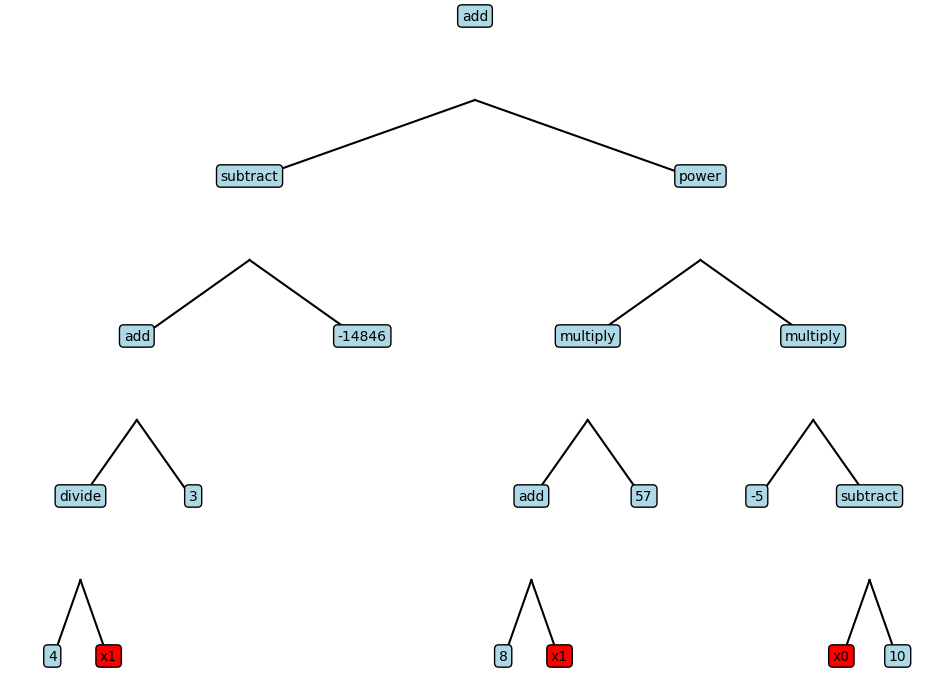

Test MSE: inf


In [ ]:
#Collapse branches that can be simplified
Tree.collapse_branch(best_tree.root,0,force_collapse=True)
print(f"Collapsed formula: {best_tree.to_np_formula()}")
print("Best Tree after collapsing:")
best_tree.add_drawing()
 
eval_formula = eval(f"lambda x: {best_tree.to_np_formula()}", {"np": np,"nan":np.nan,"inf":np.inf})
y_pred = eval_formula(x_test)
mse = np.mean(np.square(y_test - y_pred))
print(f"Test MSE: {mse}")



### Some tests

In [51]:
def f8(x):
    return np.add(np.multiply(np.multiply(np.abs(np.log(np.abs(np.cos(np.divide(np.subtract(np.subtract(x[5],-0.04935361301815182),np.sin(np.subtract(np.subtract(x[5],-0.04978842826919352),np.divide(x[5],2.564096012253908)))),np.abs(4.772087877744795)))))),np.subtract(x[5],np.abs(np.divide(np.divide(np.sin(np.divide(np.subtract(x[4],-0.04978842826919352),6.077107450793685)),np.divide(x[5],np.subtract(x[4],np.sin(np.subtract(x[4],6.112698651108903))))),np.divide(x[5],np.subtract(x[4],np.sin(np.subtract(x[4],np.sin(-1.803674288445735))))))))),4765.072335625078),-549.7154440795717) 
def f7(x):
    return np.power(np.add(np.subtract(np.negative(x[1]), np.add(6.718324352106279, x[0])), np.subtract(np.subtract(8.23243970667017, x[1]), np.subtract(-1.8826853189943655, x[1]))), np.multiply(np.divide(np.subtract(7.963879898039551, x[1]), np.multiply(x[0], 2.4722056373538397)), np.divide(np.subtract(x[1], 7.631125584398873), np.multiply(2.2134338039235306, 2.6485909722277476))))
x_all = np.concatenate((x_train, x_test), axis=1)
y_all = np.concatenate((y_train, y_test))
# x_all = x_train
# y_all = y_train
y_pred = f7(x_all)
# 403241035821000.0

mse = np.mean(np.square(y_all - y_pred))
mse

nan

In [52]:

# def test_formula(x):
#     pass



# x_tot=np.concatenate((x_train,x_test),axis=1)
# y_tot=np.concatenate((y_train,y_test))
# squared_errors = 0
# for i in range(1):
#     y_pred = test_formula(x_tot[:, i])
                 
#     squared_errors += np.square(y_tot[i] - y_pred) 

# print( squared_errors / x_tot.shape[1])
   

# def testing(tree):
#    tree.compute_fitness()
#    tree.compute_fitness2()

# cProfile.run("testing(best_tree)",sort="tottime") #for profiling so we can see the time taken by each function


# best_tree.compute_fitness()
# print(best_tree.fitness)
# best_tree.compute_fitness2()
# print(best_tree.fitness)
